In [566]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path 
import sys 
import os 
import logging
import seaborn as sns
from decimal import Decimal, ROUND_DOWN
import ast 

from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, GroupShuffleSplit
from sklearn.metrics import make_scorer ,root_mean_squared_error

from collections import Counter
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupKFold,  cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from skrub import TableVectorizer
import re 


from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report, confusion_matrix

sys.path.append('/Users/alina/Desktop/MIT/code/ADHD/MTA/helper')
from helper import  audit, ml
from helper.transformers import CorrelationSelector,PreserveFeatureNames, PreserveFeatureNamesRegressor


%load_ext autoreload
%autoreload 2

#shap.initjs()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [567]:
if Path('/Volumes/Samsung_T5/MIT/mta').exists():
    data_root =     '/Volumes/Samsung_T5/MIT/mta'
    data_derived  = '/Volumes/Samsung_T5/MIT/mta/output/derived_data'
else: 
    data_root = '/Users/alina/Desktop/MIT/code/data'
    data_derived  = '/Users/alina/Desktop/MIT/code/data/output/derived_data'

info_path = Path(data_root, "files")
#os.listdir(data_derived)

In [568]:
split_chars = "[0_]"
info_dict = {}
qsts = []

for item in os.listdir(info_path):
    if not item.startswith(".")  and not os.path.isdir(Path(info_path, item)):
        name = re.split(split_chars, item)[0]
        qsts.append(name)
        print(name)
        info_dict[name] = pd.read_csv(Path(info_path, item), usecols=['ElementName','DataType', 'ElementDescription'] )
info = pd.DataFrame()
for key, item in info_dict.items():
    info = pd.concat((info, item))


debrief
debrief14
schoolhx
diagpsx
expect
cisp
health
masc
snap
scapijus
cbcl
pcrc
medse
ssrs
wiat
demgr
scid


In [569]:
################## PREDICTORS ####################
pred = pd.read_csv(Path(data_derived, 'mta_data_clean.csv')).drop(columns = 'Unnamed: 0')
out = pd.read_csv(Path(data_derived, 'out_clean_all_raters.csv')).drop(columns = 'Unnamed: 0')
file_name_save = 'results_ML_simple_CV_RF_XGB_ODD.csv'



save_path = Path(data_derived, 'ML_results')
save_path_importances = Path(save_path, "feature_importances")
file_path_save = Path(save_path, file_name_save)



In [570]:
outcome_dict = {'ODD':  "snap_snaoddt", "HYP": "snap_snahypat", "INATT" :"snap_snainatt" , "INTERN": "ssrs_sspintt", "SS": "ssrs_ssptosst", "DOM": "pcrc_pcrcpax", "INTIM": "pcrc_pcrcprx"}
outcome_fig_dict = {'ODD':  "SNAP ODD symptoms", "HYP": "SNAP Hyperactivity Symptoms", "INATT" :"SNAP Inattention Symptoms" , "INTERN": "SSRS Internalizing Symptoms", "SS": "SSRS Social Skills", "DOM": "Parental Dominance", "INTIM": "Parent-Child Intimacy"}


In [571]:
n_remove_top_features =3
outcome_name = file_name_save.split(".")[0].split("_")[-1]

if n_remove_top_features is not None : 
    top_features_df = pd.read_csv(Path(save_path_importances, "{}_importances_full.csv".format(outcome_name))).drop(columns="Unnamed: 0")
    top_features2rem =  np.array(top_features_df["features"].iloc[:n_remove_top_features])
top_features2rem

array(['snap_snaaddwt_m', 'snap_snadbdx_m', 'snap_snap_adhd_3_m'],
      dtype=object)

In [572]:
use_params_from_result = True
if use_params_from_result :
    model_name,  corr_select,   thr_corr, params,  col_out, rater_pred, thr_drop_missing ,r2 = ml.get_params_from_best_result(file_path_save)
    rater_out = col_out[-1]
else: 
    model_name ="RandomForestRegressor" # "XGBRegressor"
    corr_select = True
    thr_corr =0.8
    params = None
    rater_pred = None 
    rater_out = "m"
    thr_drop_missing = 50
    col_out = outcome_dict[file_name_save.split(".")[0].split("_")[-1]] + "_"+ rater_out


original r2 result :  0.3127
model type XGBRegressor
corr_select : correlation_selector {'threshold': 0.8}
thr_corr:  0.8
outcome :  snap_snaoddt_m
rater input data :  m
thr drop missing:  20
params model :  {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [573]:
rater_out

'm'

In [574]:

if rater_pred is not None:
    col_pred = [ col for col in pred.columns if col.endswith(rater_pred)]
    col_pred.append("src_subject_id")
    col_pred.append('trtname')
    pred = pred[col_pred]
print(pred.columns)


Index(['expect_exp1_m', 'expect_exp2_m', 'expect_exp3_m', 'expect_exp4_m',
       'expect_exp5_m', 'expect_exp6_m', 'expect_exptott_m',
       'snap_snap_adhd_1_m', 'snap_snap_adhd_2_m', 'snap_snap_adhd_3_m',
       ...
       'scid_axoca1_m', 'scid_axoc1_m', 'scid_axgada_m', 'scid_smchk1_m',
       'scid_smchk2_m', 'scid_edanoa_m', 'scid_edbula_m', 'scid_adjchk_m',
       'src_subject_id', 'trtname'],
      dtype='object', length=279)


In [575]:
out_rater = out[['src_subject_id', col_out]]
out_rater = out_rater.rename(columns={col: f"{col}_out" for col in out_rater.columns if col != 'src_subject_id'})

data = pd.merge(out_rater, pred, how = 'left', on = 'src_subject_id')
print(data.keys())
data = audit.remove_cols(data, thr_drop_missing=thr_drop_missing) # adjust if desired, as loaded thr was 50 

y_col = col_out + "_out"
X_cols = [col for col in data.columns if col != y_col]
data = data.dropna(subset=[y_col])

y = np.array(data[y_col])
df_X = data[X_cols].drop(columns='src_subject_id')
if n_remove_top_features is not None : 
    print("removing ", top_features2rem)
    df_X = df_X.drop(columns=top_features2rem)

Index(['src_subject_id', 'snap_snaoddt_m_out', 'expect_exp1_m',
       'expect_exp2_m', 'expect_exp3_m', 'expect_exp4_m', 'expect_exp5_m',
       'expect_exp6_m', 'expect_exptott_m', 'snap_snap_adhd_1_m',
       ...
       'scid_axsima_m', 'scid_axoca1_m', 'scid_axoc1_m', 'scid_axgada_m',
       'scid_smchk1_m', 'scid_smchk2_m', 'scid_edanoa_m', 'scid_edbula_m',
       'scid_adjchk_m', 'trtname'],
      dtype='object', length=280)
Index([], dtype='object')
Removing empty columns ..  N =  0
Index([], dtype='object')
(559, 280)
Removing constant columns .. N =  0
Index([], dtype='object')
(559, 280)
Removing known and raw columns..  N =  : 0
[]
(559, 280)
Removing above threshold empty columns.. N =  : 53
{'scid_pastpsy_m', 'scid_mdca1_m', 'scid_certsom_m', 'scid_pssom_m', 'scid_certsubs_m', 'scid_grade_highed_m', 'scid_scid19_m', 'scid_mdca2_m', 'scid_mochk1_m', 'scid_maniachk_m', 'scid_edbula_m', 'scid_axsoca_m', 'cbcl_sports_time3_m', 'scid_mala_m', 'scid_psaud_m', 'scid_axoca1_m', 's

In [576]:
types_file_path = Path(data_derived, 'all_vars_description_ML.xlsx')
sheet_name='Sheet1'

In [577]:
ord_vars, cat_vars, num_vars, num_vars_in = ml.get_data_types_from_file(data, types_file_path, sheet_name)

Ordinal vars: ['snap_sna19_m', 'snap_sna20_m', 'snap_sna21_m', 'snap_sna22_m', 'snap_sna23_m', 'snap_sna24_m', 'snap_sna25_m', 'snap_sna26_m', 'snap_sna27_m', 'snap_sna28_m', 'snap_sna29_m', 'snap_sna30_m', 'snap_sna31_m', 'snap_sna32_m', 'snap_sna33_m', 'snap_sna34_m', 'snap_sna35_m', 'snap_sna36_m', 'snap_sna37_m', 'snap_sna38_m', 'snap_sna39_m', 'snap_snap_adhd_1_m', 'snap_snap_adhd_11_m', 'snap_snap_adhd_12_m', 'snap_snap_adhd_13_m', 'snap_snap_adhd_14_m', 'snap_snap_adhd_15_m', 'snap_snap_adhd_16_m', 'snap_snap_adhd_17_m', 'snap_snap_adhd_18_m', 'snap_snap_adhd_19_m', 'snap_snap_adhd_2_m', 'snap_snap_adhd_3_m', 'snap_snap_adhd_4_m', 'snap_snap_adhd_5_m', 'snap_snap_adhd_6_m', 'snap_snap_adhd_7_m', 'snap_snap_adhd_8_m', 'snap_snap_adhd_9_m', 'snap_snap_adhd_11_m', 'snap_snap_adhd_12_m', 'snap_snap_adhd_13_m', 'snap_snap_adhd_14_m', 'snap_snap_adhd_15_m', 'snap_snap_adhd_16_m', 'snap_snap_adhd_17_m', 'snap_snap_adhd_18_m', 'snap_snap_adhd_19_m', 'ssrs_s7t35_m', 'ssrs_s7t36_m', 'ssrs

/Users/alina/Desktop/MIT/code/ADHD/MTA/helper/ml.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_name = row[1]  # e.g. variable name in the spreadsheet
/Users/alina/Desktop/MIT/code/ADHD/MTA/helper/ml.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_type = row[4]  # e.g. "ord" / "num" / "cat"


In [578]:
if n_remove_top_features is not None : 
    for lst in [ord_vars, cat_vars, num_vars, num_vars_in]:
        lst[:] = [x for x in lst if x not in top_features2rem]
        

In [579]:
ml.check_overlap(num_vars_in, ord_vars, cat_vars)

Overlaps between numeric and ordinal: set()
Overlaps between numeric and categorical: set()
Overlaps between ordinal and categorical: set()
Overlaps across numeric, ordinal and categorical: set()


In [580]:
# to_remove = ['masc_ma22acx_c', 'masc_ma31hfx_c']
# ord_vars.remove(to_remove[0])
# ord_vars.remove(to_remove[1])

In [581]:

cat_vars_str, cat_vars_num, rest = [], [], []

for col in cat_vars:
    # Get the first non-null value in the column
    val = data[col].dropna().unique()[0]
    
    # Check if it's a (Python or NumPy) string
    if isinstance(val, (str, np.str_)):
        cat_vars_str.append(str(col))  # ensure column name is a Python str
    # Check if it's a (Python or NumPy) float
    elif isinstance(val, (float, np.floating)):
        cat_vars_num.append(str(col))  # ensure column name is a Python str
    else:
        rest.append(str(col))          # store in `rest` for debugging
print(cat_vars_str)
print(cat_vars_num)

['trtname']
['scid_axisidx_m', 'cbcl_special_ed_m', 'cbcl_repeat_grade_m', 'cbcl_academic_m']


In [582]:
# Define the extensions to check
extensions = ['_m', #mother 
              #'_p'# proffesionals
              '_f', # father,
              '_c',# child,
              '_t'] # teacher 

# Count columns for each extension
extension_counts = {ext: sum(col.endswith(ext) for col in pred.columns) for ext in extensions}

for ext, count in extension_counts.items():
    print(f"Columns ending with '{ext}': {count}")
    
dup_cols = df_X.columns[df_X.columns.duplicated()]
print("Duplicated column names:", dup_cols.tolist())




Columns ending with '_m': 277
Columns ending with '_f': 0
Columns ending with '_c': 0
Columns ending with '_t': 0
Duplicated column names: []


In [583]:
scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}

groups = data['src_subject_id'].values

In [584]:

#     param_distributions = { 
#     f'regressor__{key}':value for key, value in params.items()
# }
params

{'subsample': 0.8,
 'n_estimators': 100,
 'max_depth': 3,
 'learning_rate': 0.05,
 'colsample_bytree': 0.8}

In [585]:
if params is not None :  
    if model_name == "RandomForestRegressor":
        regress = RandomForestRegressor(random_state=42, **params)
    elif model_name == 'XGBRegressor':
        regress =  XGBRegressor(random_state=42, **params)
    else: 
        raise ValueError
        
else:
    if model_name == 'RandomForestRegressor':
        param_distributions = {
            'regressor__n_estimators': [100, 300],          # Correct prefix
            'regressor__max_depth': [10, None],
            'regressor__min_samples_split': [2, 10],
            'regressor__min_samples_leaf': [1, 4]
        }
        regress =  RandomForestRegressor(random_state=42)

    elif model_name == 'XGBRegressor':
        regress =  XGBRegressor(random_state=42)
        if params is None:
            param_distributions = {
            'regressor__n_estimators': [100, 300],
            'regressor__max_depth': [10],                    # Removed None
            'regressor__colsample_bytree': [0.5, 0.3],       # Mapped 'sqrt' and 'log2' to numeric values
            'regressor__min_child_weight': [2, 10, 1, 4],    # Combined 'min_samples_split' and 'min_samples_leaf'
        }

print(regress)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)


In [586]:

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler',StandardScaler())
])

ord_pipe = Pipeline([
    ('imputer', PreserveFeatureNames(SimpleImputer(strategy='mean'))),
    ('identity', PreserveFeatureNames(FunctionTransformer(lambda x: x)))
])


cat_to_dataframe = FunctionTransformer(
    func=lambda X: pd.DataFrame(X, columns=cat_vars_str),
    validate=False  # prevent extra validation that may alter the input
)

cat_str_pipe = Pipeline([
    ('imputer', PreserveFeatureNames(SimpleImputer(strategy='constant', fill_value='missing'))),
    #('to_df', cat_to_dataframe),        # conversion step added
     ('ohe', PreserveFeatureNames(TableVectorizer()))
])

cat_num_pipe = Pipeline([
    ('imputer', PreserveFeatureNames(SimpleImputer(strategy='constant', fill_value=-1))),
    ('ohe', PreserveFeatureNames(OneHotEncoder(handle_unknown="ignore")))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_vars_in),
    ('cat_str', cat_str_pipe, cat_vars_str),
    ('cat_num', cat_num_pipe, cat_vars_num),
    ('ord', ord_pipe, ord_vars)
])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
   # ('to_df', to_df_transformer),
   ('correlation_selector', CorrelationSelector(threshold=0.8)),
   #('to_df',ToDataFrameTransformer(preprocessor=preprocessor)),
    ('regressor',regress)
])

In [587]:
pipeline.fit(df_X, y)

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/skrub/_check_input.py:169: UserWarning: Only pandas and polars DataFrames are supported, but input is a Numpy array. Please convert Numpy arrays to DataFrames before passing them to skrub transformers. Converting to pandas DataFrame with columns ['0', '1', …].
  warnings.warn(
/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/skrub/_check_input.py:169: UserWarning: Only pandas and polars DataFrames are supported, but input is a Numpy array. Please convert Numpy arrays to DataFrames before passing them to skrub transformers. Converting to pandas DataFrame with columns ['0', '1', …].
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['snap_snainatt_m',
                                                   'snap_snahypat_m',
                                                   'snap_snaimput_m',
                                                   'snap_snaoddt_m',
                                                   'snap_snatotlt_m',
                                                   'snap_snahyimx_m',
                                                   'snap_snaadhdt_m',
                                                   'snap_snahit_m',
                                                   'ssrs_sspcoopt_m',
                                                   'ssrs_sspasrtt_m',
                                                   'ssrs_sspscont_m',
                                                   'ssrs...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [588]:

fig_outcome = outcome_fig_dict[file_name_save.split(".")[0].split("_")[-1]]


In [589]:
info

,ElementName,DataType,ElementDescription
0,subjectkey,GUID,The NDAR Global Unique Identifier (GUID) for r...
1,src_subject_id,String,Subject ID how it's defined in lab/project
2,interview_date,Date,Date on which the interview/genetic test/sampl...
3,interview_age,Integer,Age in months at the time of the interview/tes...
4,sex,String,Sex of subject at birth
...,...,...,...
992,scidmodb17,Integer,B17. A voice keeping up a running commentary o...
993,scidmodb18,Integer,B18. Two or more voices conversing with each o...
994,scidmodb22,Integer,B22. Gustatory delusions
995,datelastintake,Date,Date of last Intake:


In [590]:
# Define the extensions to check
extensions = ['m', #mother 
              #'_p'# proffesionals
              'f', # father,
              'c',# child,
              't'] # teacher 

# Count columns for each extension



In [591]:
rater_pred_fig = rater_pred if rater_pred is not None else "all"
rater_pred_fig

model_name_fig = "Random Forest Regressor" if model_name == "RandomForestRegressor"else "XGB Regressor"

{'m': 293, 'f': 0, 'c': 0, 't': 0}


/var/folders/hf/frc4nxb532j7gqr3_36l6kmh0000gn/T/ipykernel_92806/2381748405.py:108: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(final_labels, rotation=45, ha='right')


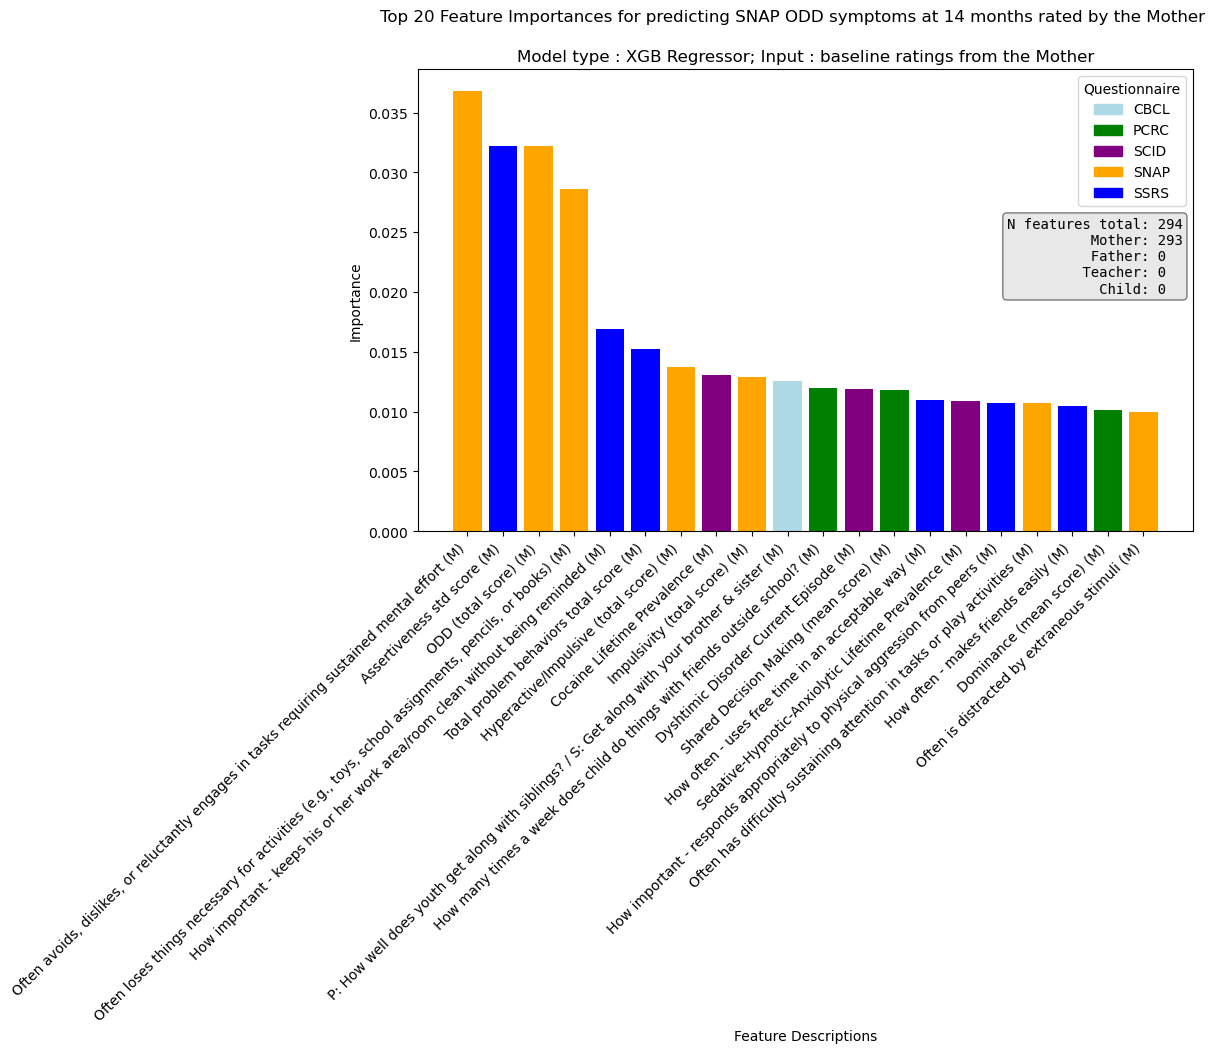

In [592]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl

# Disable LaTeX rendering for the support box.
mpl.rcParams['text.usetex'] = False

# Get processed feature names and importances.
processed_feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
importances = pipeline.named_steps['regressor'].feature_importances_
top_n = 20
indices = np.argsort(importances)[::-1][:top_n]
top_feature_names = processed_feature_names[indices]
top_importances = importances[indices]

# Count extensions (assumes extensions is defined, e.g. extensions = ["m", "f", "t", "c", "n"])
extension_counts = {ext: sum(col.endswith(ext) for col in processed_feature_names) for ext in extensions}
print(extension_counts)

# Build a support text using plain text with aligned keys.
support_data = {
    "N features total": len(processed_feature_names),
    "Mother": extension_counts.get("m", 0),
    "Father": extension_counts.get("f", 0),
    "Teacher": extension_counts.get("t", 0),
    "Child": extension_counts.get("c", 0)
}
max_key_len = max(len(key) for key in support_data.keys())
lines = []
for key, value in support_data.items():
    # Right-align the keys so the colon lines up.
    line = "{:>{width}}: {}".format(key, value, width=max_key_len)
    lines.append(line)
support_text = "\n".join(lines)

# Define questionnaire colors.
questionnaire_colors = {
    'SNAP': 'orange',
    'SSRS': 'blue',
    'PCRC': 'green',
    'SCID': 'purple',
    'CBCL': 'lightblue'
}

rater_dict = {
    "m": "the Mother", 
    "f": "the Father",
    "t": "the Teacher",
    "c": "the Child",
    "all": "All Raters"
}

def clean_description(description, questionnaires):
    # Remove a leading number and following non-letter characters.
    description = re.sub(r'^\d+[^A-Za-z]*', '', description)
    # Remove any questionnaire name (case-insensitive) at the start along with following non-letter characters.
    for q in questionnaires:
        pattern = re.compile(r'^(?i)' + re.escape(q) + r'[^A-Za-z]*')
        description = pattern.sub('', description)
    return description.strip()

def get_description(var_name, info):
    match = info[info['ElementName'].apply(lambda x: x in var_name)]
    description = match.iloc[0]['ElementDescription'] if not match.empty else var_name
    return clean_description(description, list(questionnaire_colors.keys()))

final_labels = []
bar_colors = []
questionnaires_found = set()

for feature in top_feature_names:
    # Expected format: type__questionnaire_varname_rater
    parts = feature.split('__')
    if len(parts) == 2:
        rest_parts = parts[1].split('_')
        if len(rest_parts) >= 3:
            questionnaire = rest_parts[0].upper()
            rater = rest_parts[-1].upper()
            var_name = '_'.join(rest_parts[1:-1])
            description = get_description(var_name, info)
            # If the rater is not 'C', and the description contains both Child and Parent parts,
            # extract only the Parent part (remove the literal "Parent.").
            if rater != 'C':
                parent_match = re.search(r'(?i)Parent\.\s*(.*)', description)
                if parent_match:
                    description = parent_match.group(1).strip()
            label = f"{description} ({rater})"
            final_labels.append(label)
            color = questionnaire_colors.get(questionnaire, 'grey')
            bar_colors.append(color)
            questionnaires_found.add(questionnaire)
        else:
            final_labels.append(feature)
            bar_colors.append('grey')
    else:
        final_labels.append(feature)
        bar_colors.append('grey')

# Create figure and axis.
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart.
ax.bar(final_labels, top_importances, color=bar_colors)
ax.set_xlabel("Feature Descriptions")
ax.set_ylabel("Importance")
ax.set_xticklabels(final_labels, rotation=45, ha='right')

# Set the titles.
fig.suptitle("Top {} Feature Importances for predicting {} at 14 months rated by {}".format(
    top_n, fig_outcome, rater_dict[rater_out]))
ax.set_title("Model type : {}; Input : baseline ratings from {}".format( model_name_fig,
    rater_dict[rater_pred_fig]))

ax.set_xticks(range(len(final_labels)))
ax.set_xticklabels(final_labels, rotation=45, ha='right')
# Add the support text box (using plain text with monospace font).
ax.text(0.76,0.68, support_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='left',
        fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

# Create a legend for the questionnaires.
legend_handles = [Patch(color=questionnaire_colors.get(q, 'grey'), label=q) for q in questionnaires_found]
ax.legend(handles=legend_handles, title="Questionnaire",loc='upper right', bbox_to_anchor=(1, 1) )

plt.show()

In [593]:

save_path_importances

PosixPath('/Users/alina/Desktop/MIT/code/data/output/derived_data/ML_results/feature_importances')

In [594]:

indices_importances = np.argsort(importances)[::-1][:-1]
top_feature_names_all = processed_feature_names[indices]
top_importances_all = importances[indices]

In [595]:
idx_impo_all = np.argsort(importances)[::-1][:-1]
top_feature_names_all = processed_feature_names[idx_impo_all]
top_importances_all = importances[idx_impo_all]

In [596]:
prefixes = ['num__','cat_str__','cat_num__', 'ord__']

pattern = re.compile(r'^(' + '|'.join(map(re.escape, prefixes)) + ')')


top_feature_names_all_short= [pattern.sub('', name) for name in top_feature_names_all]

In [597]:
top_feature_names_all
top_importances_all.shape

(192,)

In [598]:
columns = ["features","features_model" , "importances"]

In [599]:
importances_df = pd.DataFrame({"features": top_feature_names_all_short ,"features_model": top_feature_names_all, "importanecs": top_importances_all})

In [600]:
importances_df

,features,features_model,importanecs
0,snap_snap_adhd_6_m,ord__snap_snap_adhd_6_m,0.036787
1,ssrs_sspasrtt_m,num__ssrs_sspasrtt_m,0.032243
2,snap_snaoddt_m,num__snap_snaoddt_m,0.032236
3,snap_snap_adhd_7_m,ord__snap_snap_adhd_7_m,0.028613
4,ssrs_s7t45_m,ord__ssrs_s7t45_m,0.016891
...,...,...,...
187,snap_snap_adhd_14_m,ord__snap_snap_adhd_14_m,0.000000
188,snap_snap_adhd_18_m,ord__snap_snap_adhd_18_m,0.000000
189,snap_snap_adhd_19_m,ord__snap_snap_adhd_19_m,0.000000
190,ssrs_sst16_m,ord__ssrs_sst16_m,0.000000


In [601]:
#importances_df.to_csv(Path(save_path_importances, "INTIM_importances_full.csv"))

In [602]:
top_features2rem

array(['snap_snaaddwt_m', 'snap_snadbdx_m', 'snap_snap_adhd_3_m'],
      dtype=object)